<h1> Lecture 11 : Least-Squares Fitting </h1>



<h3> Exercise 11.1 </h3>

<p>After defining, in a dedicated library, a linear function phi(x,theta) with two parameters: 
<ul> 
<li> Write a program that generates a set of 10 pairs (x_i,y_i) such that the points x_i are randomly distributed along the horizontal axis between 0 and 10, and the points y_i are constructed using the formula y_i = phi(x,theta) + e_i.</li>
<li> Plot the obtained sample, including the expected error bars. </li>
</ul>
</p>

<ErrorbarContainer object of 3 artists>

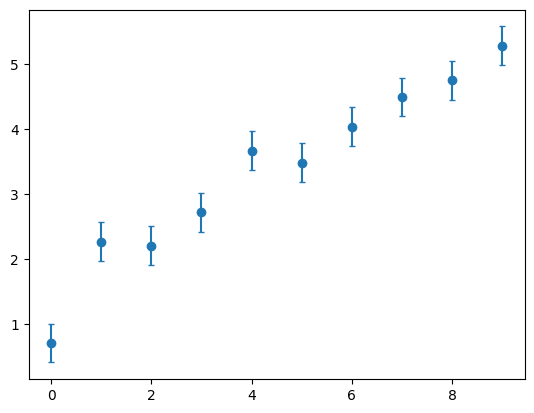

In [22]:
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt
import myrand as rand

#- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
# This method define a generic linear function respect the theta parameters and x observable variable
#- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


def phi(x,theta,f):

    if len(theta) == 1 : raise ValueError('theta must have dimension greater than 1')

    if len(f) == 1 : raise ValueError('f must have dimension greater than 1')

    if len(f) != len(theta): raise ValueError('f and theta must have same dimensione')

    yi = 0
    for i in range(len(theta)):
        y = f[i](x)*theta[i]
        yi += y

    return yi


theta = [0.5,1.1]
f = [lambda x:  x , lambda x : 1]

epsilon_sigma = 0.3

epsilon = rand.generate_TCL_ms(0.,epsilon_sigma,10)

xcoord = np.arange(0,10,1)
ycoord = []

for i in range (xcoord.size):
    ycoord.append(phi(xcoord[i],theta,f) + epsilon[i])
sigma_y = epsilon_sigma*np.ones(len(ycoord))

plt.errorbar(xcoord,ycoord,yerr = sigma_y, linestyle = 'none', marker = 'o', capsize = 2.0) 



<h3> Exercise 11.2 </h3>

<p> Use the iMinuit library to perform a fit on the simulated sample. </p>
<ul> 
<li> Check if the fit was successful </li>
<li> Print the values of the determined parameters and theri sigma on screen</li>


</ul>

<h3> Exercise 11.3 </h3>

<ul> 

<li> Calculate the value of Q^2 using the points and the fitted function obtained in the previous exercise. </li> 
<li> Compare the value obtained with iminuit with the calculated one.  </li>
<li> Print the value of the degrees of freedom of the fit </li>

</ul>

<h3> Exercise 11.6 </h3>

<p> Add to Exercise 11.3 the screen printout of the entire covariance matrix of the fit parameters. </p>



In [105]:
from iminuit import Minuit
from iminuit.cost import LeastSquares

def func (x,m,q):
    return m*x + q

def qsquared(x,y,sigma_y,f,m,q):
    
    Q_squared = 0

    for i in range(len(x)):    
        Q_squared = Q_squared +  pow((y[i]-f(x[i],m,q))/sigma_y[i],2)
    
    return Q_squared


epsilon_sigma = 0.3

epsilon = rand.generate_TCL_ms(0.,epsilon_sigma,10)

x_coord = np.arange(0,10,1)
y_coord = np.zeros(10)

for i in range (x_coord.size):
    y_coord[i] = func(x_coord[i],0.5,1.1) + epsilon[i]

sigma_y = epsilon_sigma*np.ones(len(y_coord))


least_squares = LeastSquares (x_coord, y_coord, sigma_y,func)
my_minuit = Minuit (least_squares, m = 0, q = 0)  # starting values for m and q
my_minuit.migrad ()  # finds minimum of least_squares function
my_minuit.hesse ()   # accurately computes uncertainties


# NB: adding additional instructions prevents the automatic visualisation of the fit result

is_valid = my_minuit.valid
print('Success of the fit: ', is_valid)

m_fit = my_minuit.values[0]
q_fit = my_minuit.values[1]

errM = my_minuit.errors[0]
errQ = my_minuit.errors[1]

print('m = ', m_fit,'q = ', q_fit )
print('err m = ', errM)
print('err q = ', errQ)

Qsquare = qsquared(x_coord,y_coord,sigma_y,func,m_fit,q_fit)

print('Q^2 from own algorithm = ', Qsquare)

Q_squared = my_minuit.fval

print('value of the fit Q-squared using iminuit library: ', Q_squared)

print('The difference between the two Q^2 is :', abs(Q_squared-Qsquare))

print('the degress of freedoms of the fit are: ', my_minuit.ndof)

print (my_minuit.covariance)
print ('variance of the first parameter (m):', my_minuit.covariance[0][0])
print ('variance of the second parameter (q):', my_minuit.covariance[1][1])
print ('covariance of the two parameters:', my_minuit.covariance[1][0])

Success of the fit:  True
m =  0.4522320515902576 q =  1.3779125089891606
err m =  0.033028928364006414
err q =  0.17632622352645852
Q^2 from own algorithm =  2.1171902508390623
value of the fit Q-squared using iminuit library:  2.1171902508390623
The difference between the two Q^2 is : 0.0
the degress of freedoms of the fit are:  8.0
┌───┬─────────────────┐
│   │       m       q │
├───┼─────────────────┤
│ m │ 0.00109 -0.0049 │
│ q │ -0.0049  0.0311 │
└───┴─────────────────┘
variance of the first parameter (m): 0.0010909101088746676
variance of the second parameter (q): 0.031090937103102616
covariance of the two parameters: -0.004909096213977959


<h3> Exercise 11.4 </h3>

<p> Using the toy experiments technique, generate 10,000 fit experiments with the model studied in the previous exercises and fill a histogram with the obtained values of Q^2. </p>
<ul>
<li>Compare the expected value of Q^2 obtained from the toy experiments with the degrees of freedom of the problem. </li>
</ul>

Number of degree of fredom of the problem =  8.0
Q^2 expected value =  7.9654226104695045
The value obtained is near the the expected value of a Q^2 distribution that coincide with number of degree of freedom


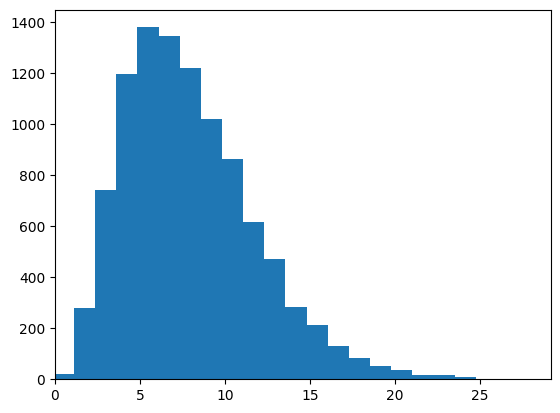

In [87]:
import stats as stats
from math import ceil


#This function calculate the optimal numbers of bins for making an in Histogram un function of the number of 
#events

def sturges(N_events):
    if len(N_events) != 1 :
        return ceil(1+3.322 * np.log(len(N_events)))
    else:
        return ceil(1+3.322 * np.log(N_events))

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

NToys = 10000

epsilon_sigma = 0.3
m_true = 0.5
q_true = 1.1

Q2 = []


for i in range(NToys):
    epsilon = rand.generate_TCL_ms(0.,epsilon_sigma,10)
    x_coord = np.arange(0,10,1)
    y_coord = np.zeros(10)

    for i in range (x_coord.size):
        y_coord[i] = func(x_coord[i],m_true,q_true) + epsilon[i]

    sigma_y = epsilon_sigma*np.ones(len(y_coord))


    least_squares = LeastSquares (x_coord, y_coord, sigma_y,func)
    my_minuit = Minuit (least_squares, m = 0, q = 0)  # starting values for m and q
    my_minuit.migrad ()  # finds minimum of least_squares function
    my_minuit.hesse ()   # accurately computes uncertainties
    Q2.append(my_minuit.fval)


nbins = sturges(Q2)
measure = stats.stats(Q2)

xmin = measure.mean() - 5.*measure.sigma()
xmax = measure.mean() + 5.*measure.sigma()

measure = stats.stats(Q2)

bins_edges = np.linspace(xmin,xmax,nbins)

plt.hist(Q2,bins = bins_edges)
plt.xlim(0.)

print('Number of degree of fredom of the problem = ', my_minuit.ndof)
print('Q^2 expected value = ' , measure.mean())
print('The value obtained is near the the expected value of a Q^2 distribution that coincide with number of degree of freedom')


<h3> Exercise 11.5 </h3>
<p>Modify the previous program by deliberately changing the experimental uncertainty associated with the points y_i
 in the sample and verify that it’s possible to recover the uncertainty used in generating the points through the expected value of the variable Q^2.</p>

In [103]:
NToys = 10000
epsilon_sigma = 0.3
epsilon_sigma_mod = 0.4 * epsilon_sigma
x_coord = np.arange(0,10,1)
y_coord = np.zeros(10)

Q2 = []

for i in range(NToys):

    epsilon = rand.generate_TCL_ms(0.,epsilon_sigma_mod,10)

    for i in range (x_coord.size):
        y_coord[i] = func(x_coord[i],0.5,1.1) + epsilon[i]

    sigma_y = epsilon_sigma*np.ones(len(y_coord))

    least_squares = LeastSquares (x_coord, y_coord, sigma_y,func)
    my_minuit = Minuit (least_squares, m = 0, q = 0)  # starting values for m and q
    my_minuit.migrad ()  # finds minimum of least_squares function
    my_minuit.hesse ()   # accurately computes uncertainties
    Q2.append (my_minuit.fval)
    

alpha = stats.stats(Q2)

Q2mean = alpha.mean()
factor = sqrt(Q2mean/my_minuit.ndof)
print('the factore of scale used was = ', factor)



the factore of scale used was =  0.40021172579869285
